## 1. Problem statement

We want to develop a classifier to detect ASMR from EEG data using topological features, and identify the electrodes with the strongest signal responses.

## 2. Data loading

We will use EEG data from the following study:

Swart, T. (2022, January 11). ASMR amplifies low frequency and reduces high frequency oscillations. Retrieved from osf.io/dg3y5

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from data import read_raw_data


raw_data = read_raw_data(n_people=1)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 3 misc
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 512.0 Hz
>
Using matplotlib as 2D backend.


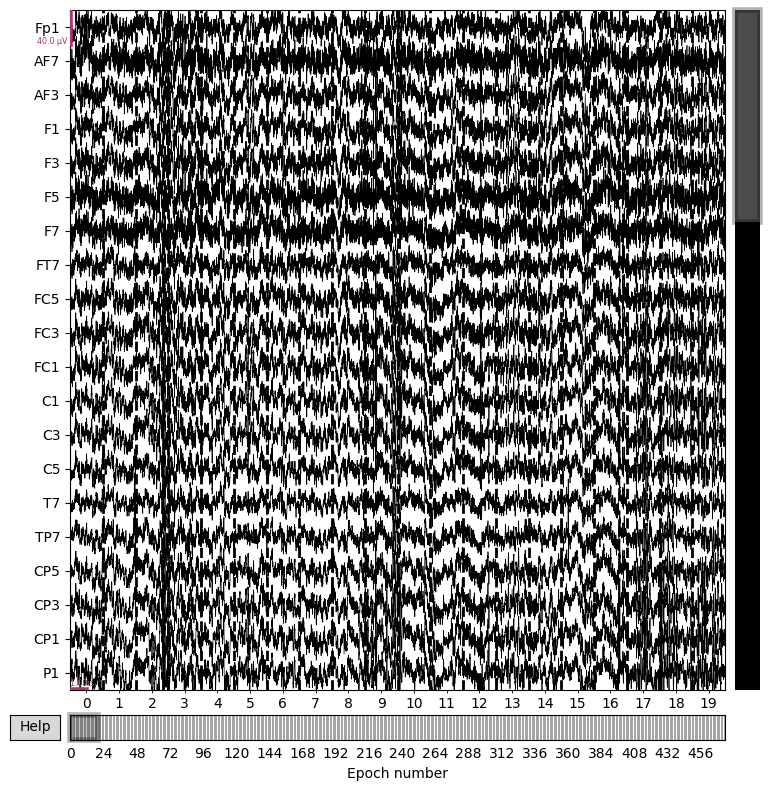

In [3]:
import matplotlib.pyplot as plt


_, raw = raw_data[0]
print(raw.info)
fig = raw.plot(show=False)
plt.show()

## 3. Data processing

The EEG data will undergo the following processing:

1) Segmentation into labeled intervals;
2) Conversion of the time series from each segment and channel into point clouds.

In [4]:
from data import get_processed_data


df = get_processed_data()
df

,id,interval,point_cloud,label
0,002,"[[-1.8779748916625974e-05, -2.0042818069458006...","[[[-1.5448399543762206e-05, -1.541908860206604...",B1(Pre_Baseline)
1,002,"[[1.2216014862060546e-05, 1.1537410736083984e-...","[[[5.991719722747802e-06, 3.423708438873291e-0...",B1(Pre_Baseline)
2,002,"[[-3.148919641971588e-07, -3.3316106796264646e...","[[[1.1420682907104491e-05, 3.2277607917785643e...",B1(Pre_Baseline)
3,002,"[[-1.1134177207946776e-05, -1.2960216522216797...","[[[-9.962596893310546e-06, 5.689457416534424e-...",B1(Pre_Baseline)
4,002,"[[-5.894306659698486e-06, -4.900899887084961e-...","[[[-1.5238103866577147e-05, 3.1441509723663328...",B1(Pre_Baseline)
...,...,...,...,...
10754,081,"[[7.206916332244873e-06, 1.50133216381073e-06,...","[[[-1.858909249305725e-06, 5.659111976623535e-...",B5(Post_Relaxed)
10755,081,"[[-7.881077766418457e-06, -9.90039825439453e-0...","[[[-6.632114887237549e-06, -1.3829706192016601...",B5(Post_Relaxed)
10756,081,"[[6.584407329559326e-06, 1.109909152984619e-05...","[[[1.6267745971679686e-05, 1.3056303977966308e...",B5(Post_Relaxed)
10757,081,"[[-1.712510871887207e-05, -1.994163703918457e-...","[[[-1.4927484512329101e-05, -1.074840545654296...",B5(Post_Relaxed)


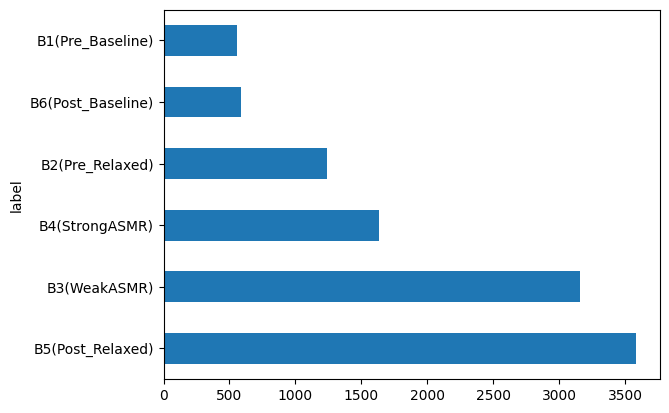

In [5]:
df['label'].value_counts().plot(kind='barh')
plt.show()

The class distribution in our dataset is unbalanced, necessitating careful selection of performance metrics to accurately assess our classifier.

Let's take a look at some of the segments.

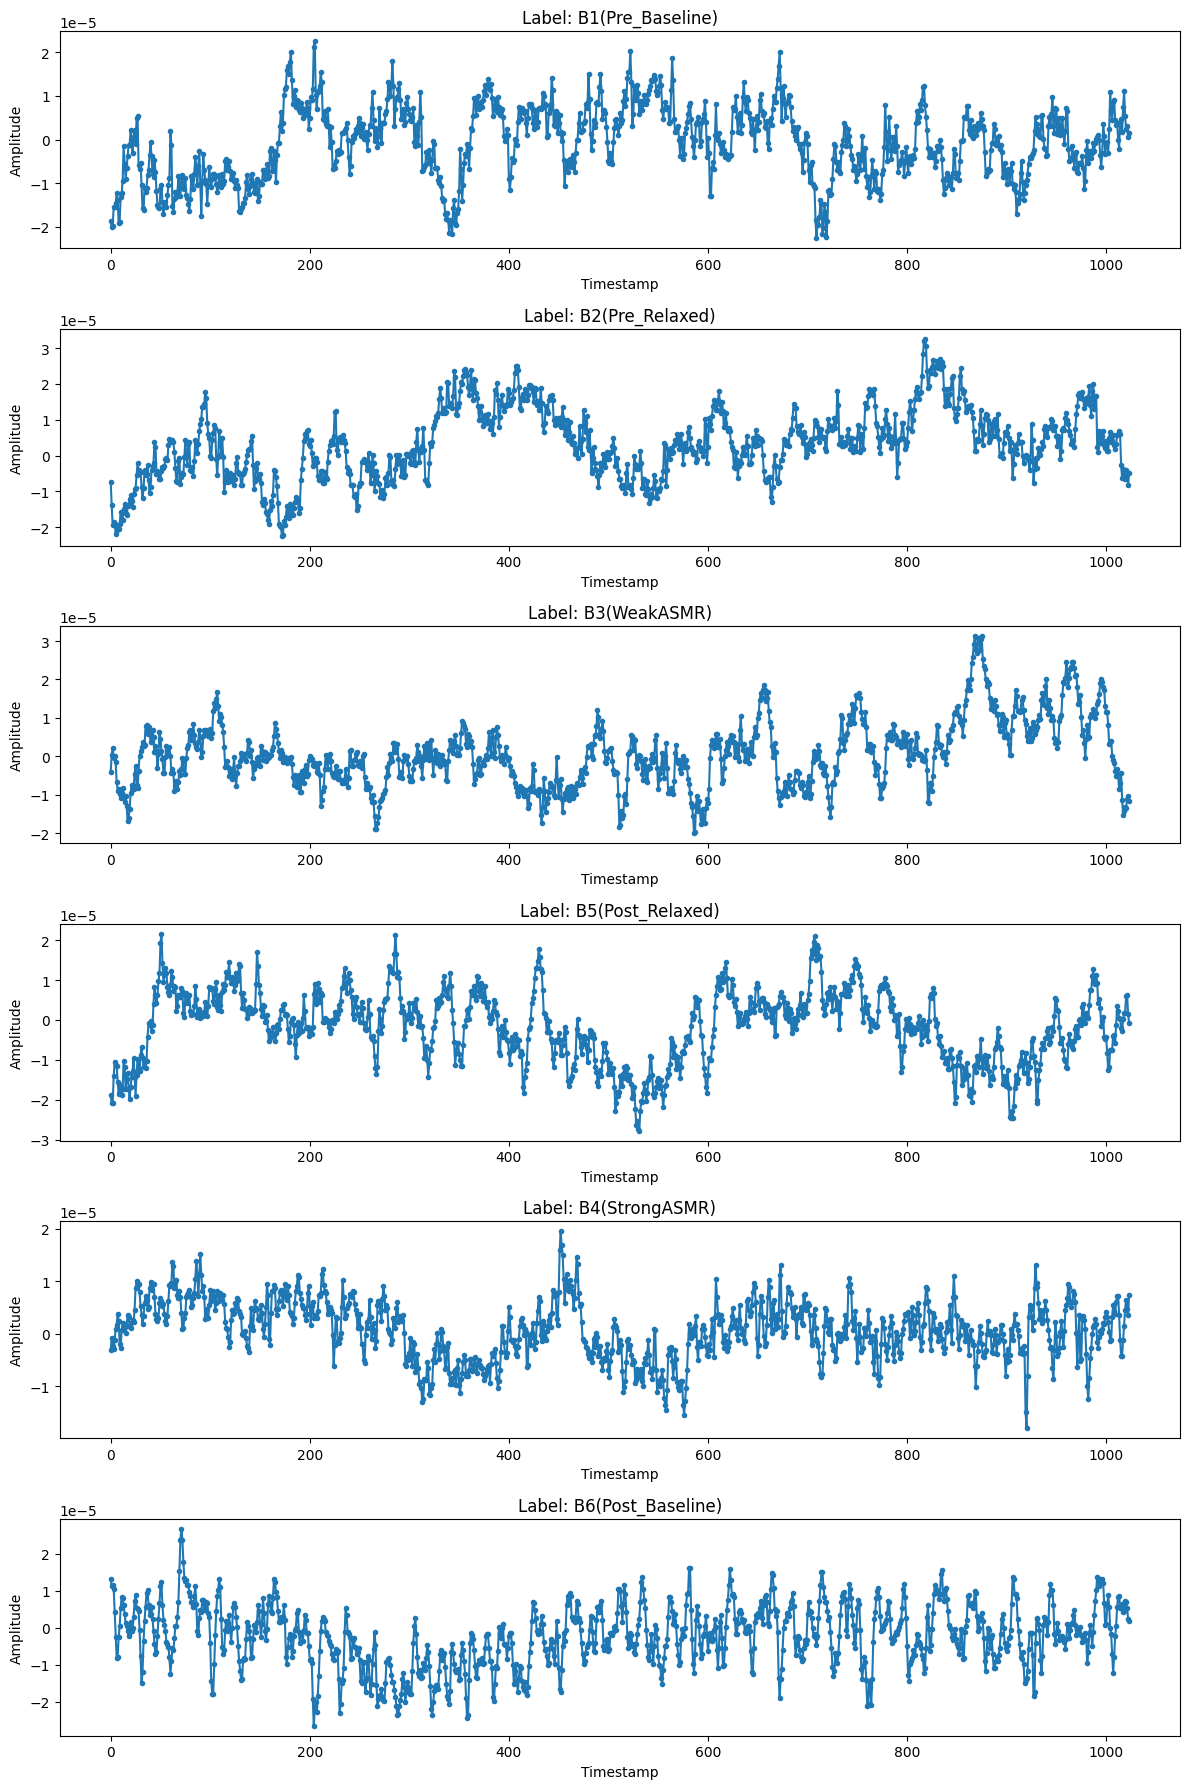

In [6]:
samples = df.groupby('label').head(1)

fig, axs = plt.subplots(nrows=len(samples), figsize=(12, len(samples) * 3))

for ax, (_, row) in zip(axs, samples.iterrows()):
    ax.plot(row['interval'][0, :], marker='.', linestyle='-') 
    ax.set_title(f"Label: {row['label']}")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

Let's also look at the point clouds.

Label: B1(Pre_Baseline)


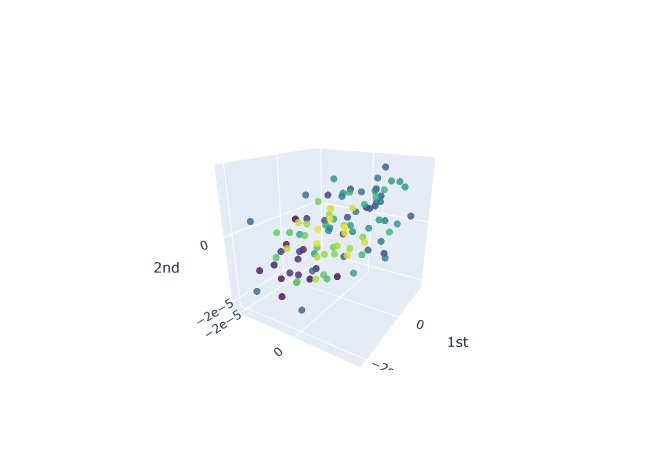

In [19]:
from gtda.plotting import plot_point_cloud

from visualization import visualize


label = 'B1(Pre_Baseline)'
print(f'Label: {label}')
fig = plot_point_cloud(df[df['label'] == label]['point_cloud'].iloc[0][0])
visualize(fig, 'point_cloud_1')

Label: B4(StrongASMR)


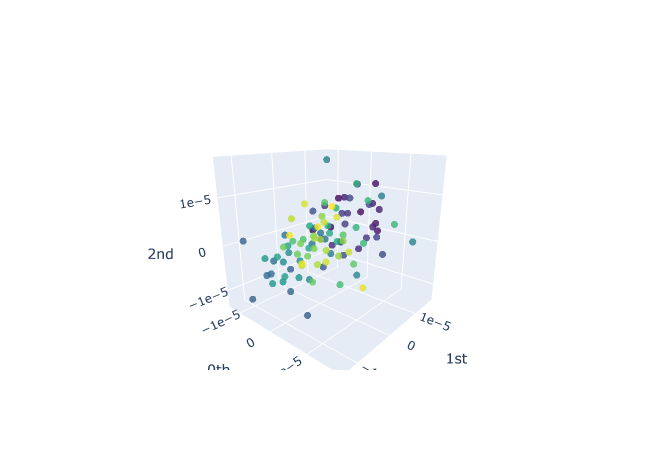

In [21]:
label = 'B4(StrongASMR)'
print(f'Label: {label}')
fig = plot_point_cloud(df[df['label'] == label]['point_cloud'].iloc[0][0])
visualize(fig, 'point_cloud_4')

## 4. Topological feature extraction

In [32]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram


VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])

samples = df.groupby('label').head(1).sort_values(by='label')

def plot_persistence_diagram(samples, idx):
    print(f"Label: {samples['label'].iloc[idx]}")
    diagrams = VR.fit_transform(samples['point_cloud'].iloc[idx])
    fig = plot_diagram(diagrams[0])
    visualize(fig, f'persistence_diagram_{idx+1}')

Label: B1(Pre_Baseline)


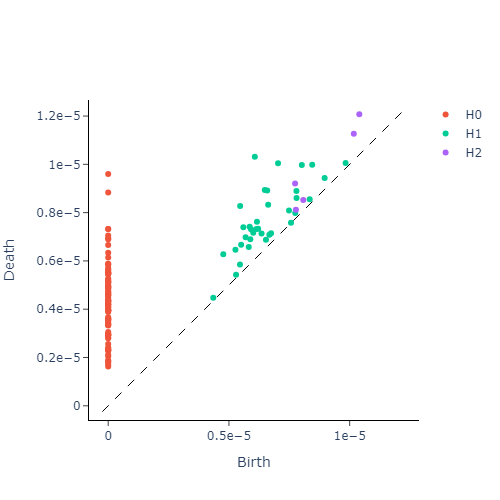

In [34]:
plot_persistence_diagram(samples, 0)

Label: B4(StrongASMR)


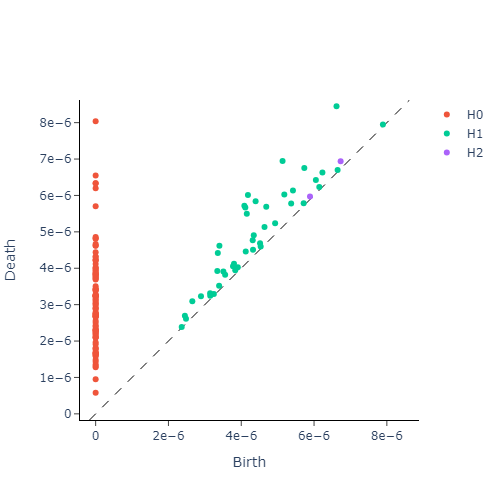

In [36]:
plot_persistence_diagram(samples, 3)

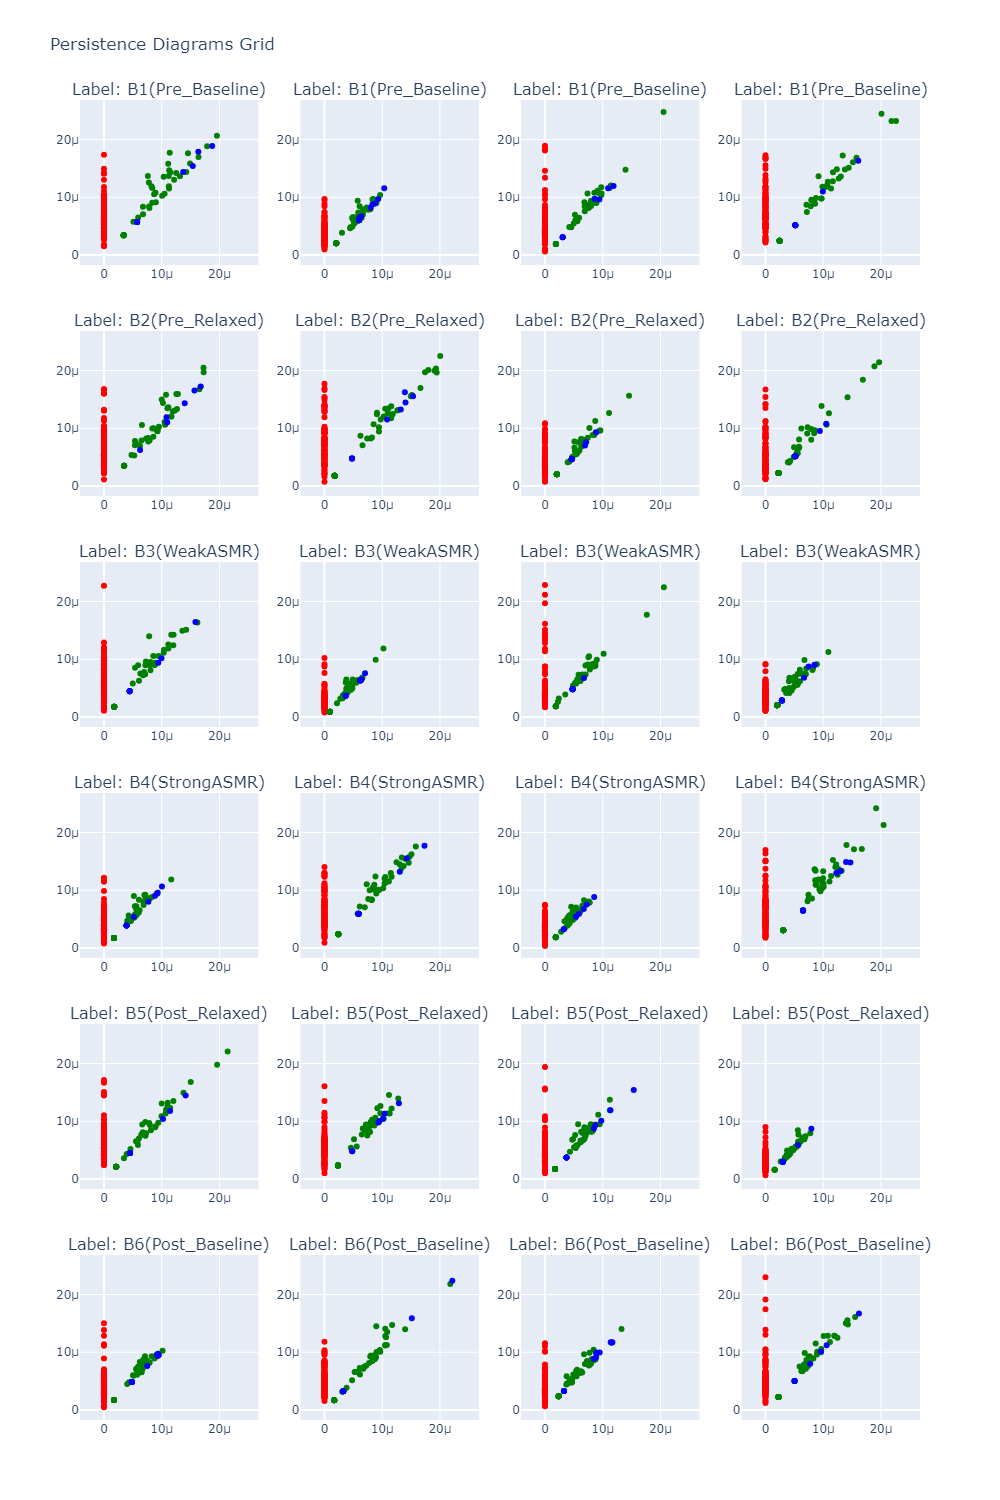

In [37]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from config import SEED


n_samples = 4

samples = df.groupby('label').sample(n=n_samples, random_state=SEED).reset_index(drop=True)

labels = sorted(df['label'].unique())

fig = make_subplots(rows=6, 
                    cols=n_samples, 
                    subplot_titles=[f'Label: {label}' for label in labels for _ in range(n_samples)], 
                    vertical_spacing=0.05)

row = 1
col = 1

for label in labels:
    for idx in range(n_samples):
        sample = samples[(samples['label'] == label)].iloc[idx]
        diagrams = VR.fit_transform(sample['point_cloud'])
        diagram = diagrams[0] # Only the first channel is used

        conditions = [
            diagram[:, 2] == 0,
            diagram[:, 2] == 1,
            diagram[:, 2] == 2
        ]
        choices = ['red', 'green', 'blue']
        colors = np.select(conditions, choices)

        trace = go.Scatter(x=diagram[:, 0], y=diagram[:, 1], mode='markers', marker=dict(color=colors))
        
        fig.add_trace(trace, row=row, col=col)
        
        if col < n_samples:
            col += 1
        else:
            col = 1
            row += 1

fig.update_xaxes(matches='x')
fig.update_yaxes(matches='y', scaleanchor='x', scaleratio=1)

fig.update_layout(height=1500, width=1000, title_text='Persistence Diagrams Grid', showlegend=False)
visualize(fig, 'persistence_diagrams_grid')

## 5. Classification

In [1]:
from data import get_training_data


X_train, X_val, y_train, y_val = get_training_data()

/mnt/d/MyDesktop/Проект/asmr-tda/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [2]:
X_train

,id,channel,PE_0,PE_1,PE_2
0,039,Fp1,6.468270,4.184511,1.890369
1,039,Fp1,6.462400,4.436456,2.450219
2,039,Fp1,6.476289,4.368788,0.822838
3,039,Fp1,6.465686,4.310231,1.694343
4,039,Fp1,6.427770,4.639088,1.454506
5,039,Fp1,6.481198,4.276833,2.106573
6,039,Fp1,6.535502,4.663363,2.336894
7,039,Fp1,6.532877,4.557506,1.754963
8,039,Fp1,6.490019,4.287614,0.658481
9,039,Fp1,6.524999,4.519779,1.128632


In [3]:
X_val

,id,channel,PE_0,PE_1,PE_2
0,039,Fp1,6.494108,4.444284,1.143532
1,039,Fp1,6.532478,4.773223,1.609371
2,039,Fp1,6.430763,4.606714,0.976683
3,039,Fp1,6.493014,4.609844,1.064843
4,039,Fp1,6.507456,4.535821,0.210742
5,039,Fp1,6.398626,4.210202,0.000000
6,039,Fp1,6.425825,3.918844,1.138601
7,039,Fp1,6.504895,4.490919,0.000000
8,039,Fp1,6.523423,4.398676,0.991844
9,039,Fp1,6.478366,4.635731,1.265817


In [4]:
y_train

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
Name: ASMR, dtype: bool

In [5]:
y_val

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
Name: ASMR, dtype: bool

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from config import SEED


column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['id', 'channel'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', RandomForestClassifier(random_state=SEED))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f'Val accuracy: {accuracy:.2f}')

y_probs = pipeline.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_probs)
print(f'Val ROC-AUC: {roc_auc}')

Val accuracy: 0.30
Val ROC-AUC: 0.29


In [14]:
y_pred = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f'Train accuracy: {accuracy:.2f}')

y_probs = pipeline.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_probs)
print(f'Train ROC-AUC: {roc_auc}')

Train accuracy: 1.00
Train ROC-AUC: 1.0


## 6. Experiments

### TODO:

try different embeddings 

try different features

try different classifiers

## 7. Locating brain regions

### TODO:

PCA/SVD/etc

find the most informative channels

visualize the locations of the corresponding sensors on the brain